In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=True   # mettre True si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





Loading BokehJS ...

In [3]:
#%% fonction pour voir une image




def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

  


In [4]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex128)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex128)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [5]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



Text(0.5, 1.0, 'Noisy image')

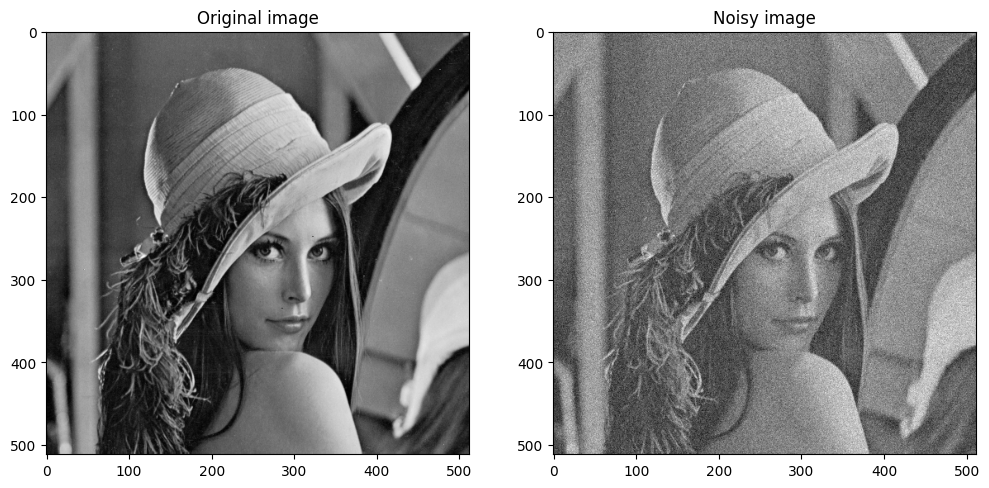

In [9]:
#%%
fig, ax = plt.subplots(1,2,figsize=(12,7))
# voir l'image
ax[0].imshow(im,cmap='gray')
ax[0].set_title("Original image")
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
ax[1].imshow(imb,cmap='gray')
ax[1].set_title("Noisy image")

## I-Debruitage par régularisation quadratique

1.  La fonction resoud_quad_fourier résoud un problème de minimisation de la forme $\sum_i ||K_i*im-V_i||^2$. On peut donc choisir un noyau K qui effectue un calcul de gradient sur l'image im, ce qui est fait dans la fonction minimisation_quadratique, pour résoudre notre problème : $min_u ||u-v||^2+\lambda||\nabla u||^2$.
2.  Avec lambda très faible, l'image obtenue est l'image observée car on minimise $||u-v||^2$. Au contraire, avec lambda très grand, on minimise seulement $||\nabla u||^2$, on tend donc vers une image d'intensité constante.

Text(0.5, 1.0, 'Quadratic restored image')

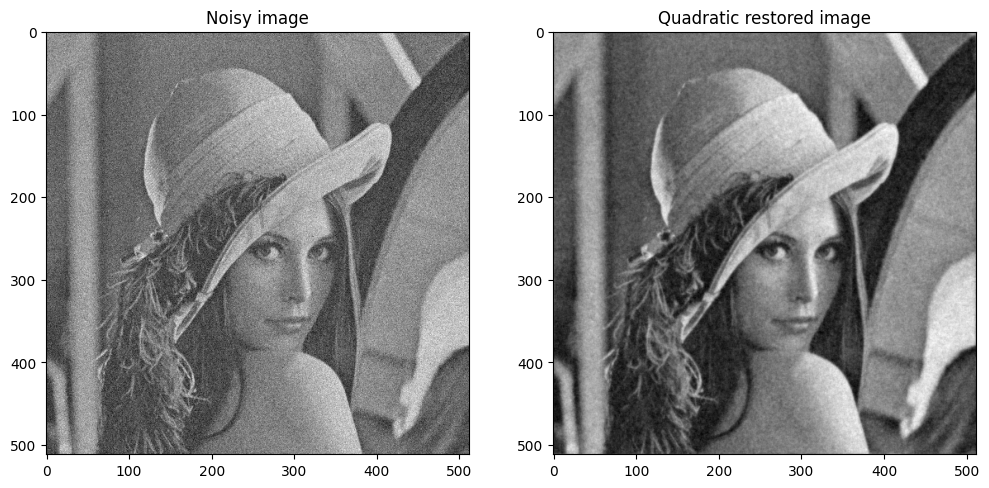

In [10]:
#%% restauration quadratique : exemple
lamb=1
restau=minimisation_quadratique(imb,lamb)
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(imb,cmap='gray')
ax[1].imshow(restau, cmap='gray')
ax[0].set_title("Noisy image")
ax[1].set_title("Quadratic restored image")



3.  

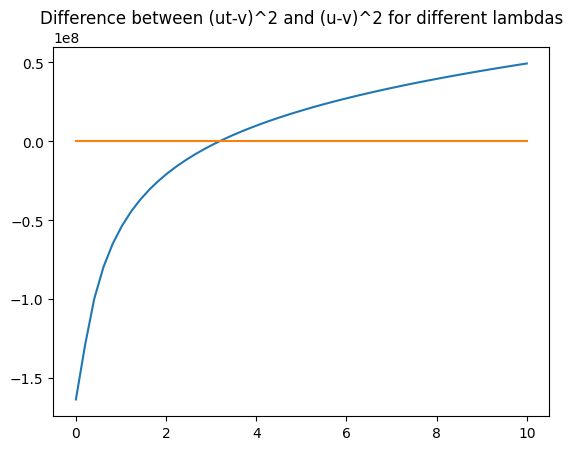

In [11]:
ecart = norm2(imb-im)**2
x = np.linspace(0,10,50)
l=[]
for i in x:
    ut = minimisation_quadratique(imb,i)
    l.append(norm2(ut-imb)**2-ecart)
plt.plot(x,l)
plt.plot(x,[0 for _ in range(50)])
plt.title("Difference between (ut-v)^2 and (u-v)^2 for different lambdas")
plt.show()

163577482.08929026
lambda = 3.184049259608792
ecart final = 0.0


Text(0.5, 1.0, 'Image at the same distance from noisy image as the original')

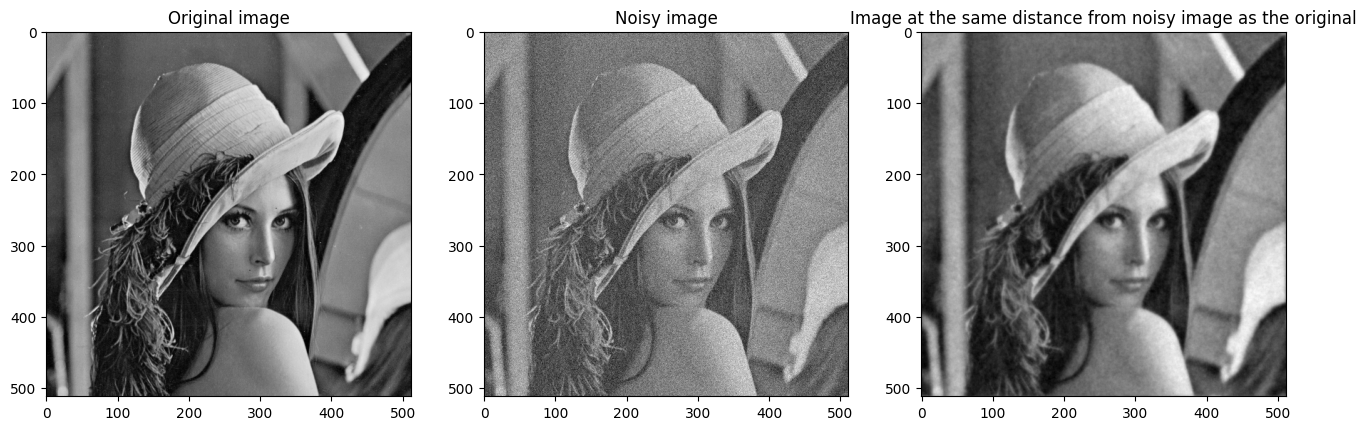

In [12]:
ecart = norm2(imb-im)**2
print(ecart)
l1 = 0
l2 = 10
N = 50
for i in range(N):
    m = (l1+l2)/2
    utildem = minimisation_quadratique(imb,m)
    ecart5 = norm2(imb-utildem)**2
    if ecart5 < ecart:
        l1 = m
    else:
        l2 = m

utilde = minimisation_quadratique(imb,(l1+l2)/2)

print("lambda =",(l1+l2)/2)
print("ecart final =",np.abs(ecart-norm2(imb-utilde)**2))
fig, ax = plt.subplots(1,3,figsize=(16,7))
ax[0].imshow(im,cmap='gray')
ax[1].imshow(imb, cmap='gray')
ax[2].imshow(utilde, cmap='gray')
ax[0].set_title("Original image")
ax[1].set_title("Noisy image")
ax[2].set_title("Image at the same distance from noisy image as the original")

4. Il existe effectivement un meilleur paramètre lambda mais celui-ci ne produit pas une image en tout point semblable à l'image originale. La méthode de reconstruction quadratique permet une bonne reconstruction mais renvoie une image floutée qui empêche la reconstruction parfaite.

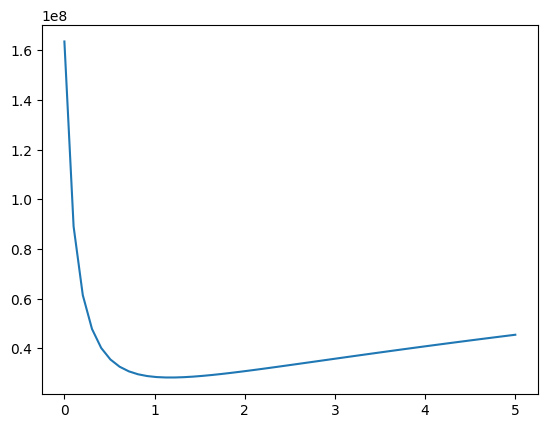

Best lambda = 1.1720920138888893
Minimum difference = 28291816.58540585


Text(0.5, 1.0, 'Best quadratic restored image')

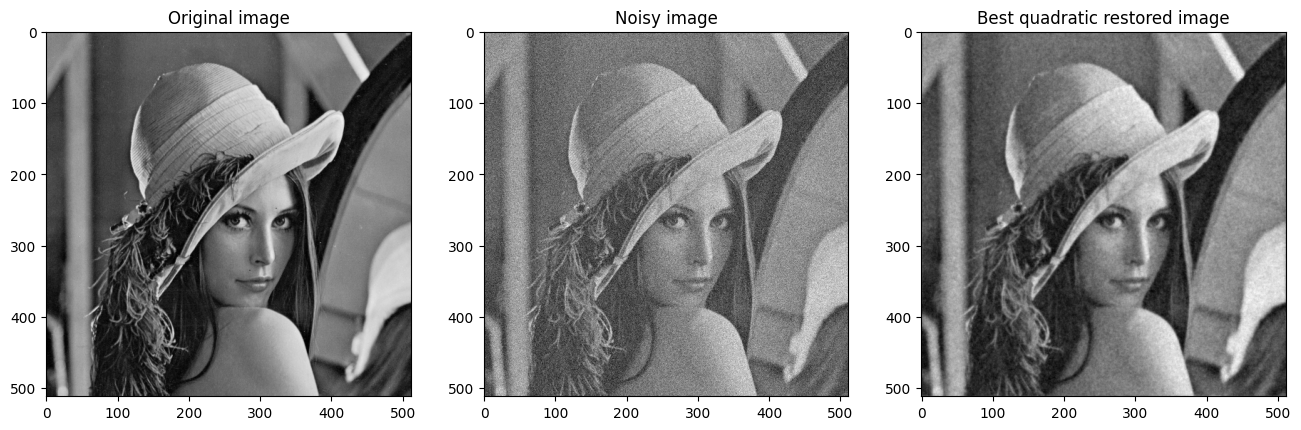

In [13]:
x = np.linspace(0,5,50)
l=[]
for i in x:
    ut = minimisation_quadratique(imb,i)
    l.append(norm2(ut-im)**2)
plt.plot(x,l)
plt.show()

left=0
right=2
step = 0.5
for i in range(10):
    l = []
    for j in np.linspace(left,right,10):
        l.append(norm2(minimisation_quadratique(imb,j)-im)**2)
    ind = np.argmin(np.array(l))
    best_lambda = left+(right-left)/9*ind
    left = best_lambda-step/(2**i)
    right = best_lambda+step/(2**i)

best_restau = minimisation_quadratique(imb,best_lambda)

print("Best lambda =",best_lambda)
print("Minimum difference =", norm2(best_restau-im)**2)

fig, ax = plt.subplots(1,3,figsize=(16,7))
ax[0].imshow(im,cmap='gray')
ax[1].imshow(imb, cmap='gray')
ax[2].imshow(best_restau, cmap='gray')
ax[0].set_title("Original image")
ax[1].set_title("Noisy image")
ax[2].set_title("Best quadratic restored image")


## II- Débruitage par variation totale

### 2.1 Descente de gradient

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


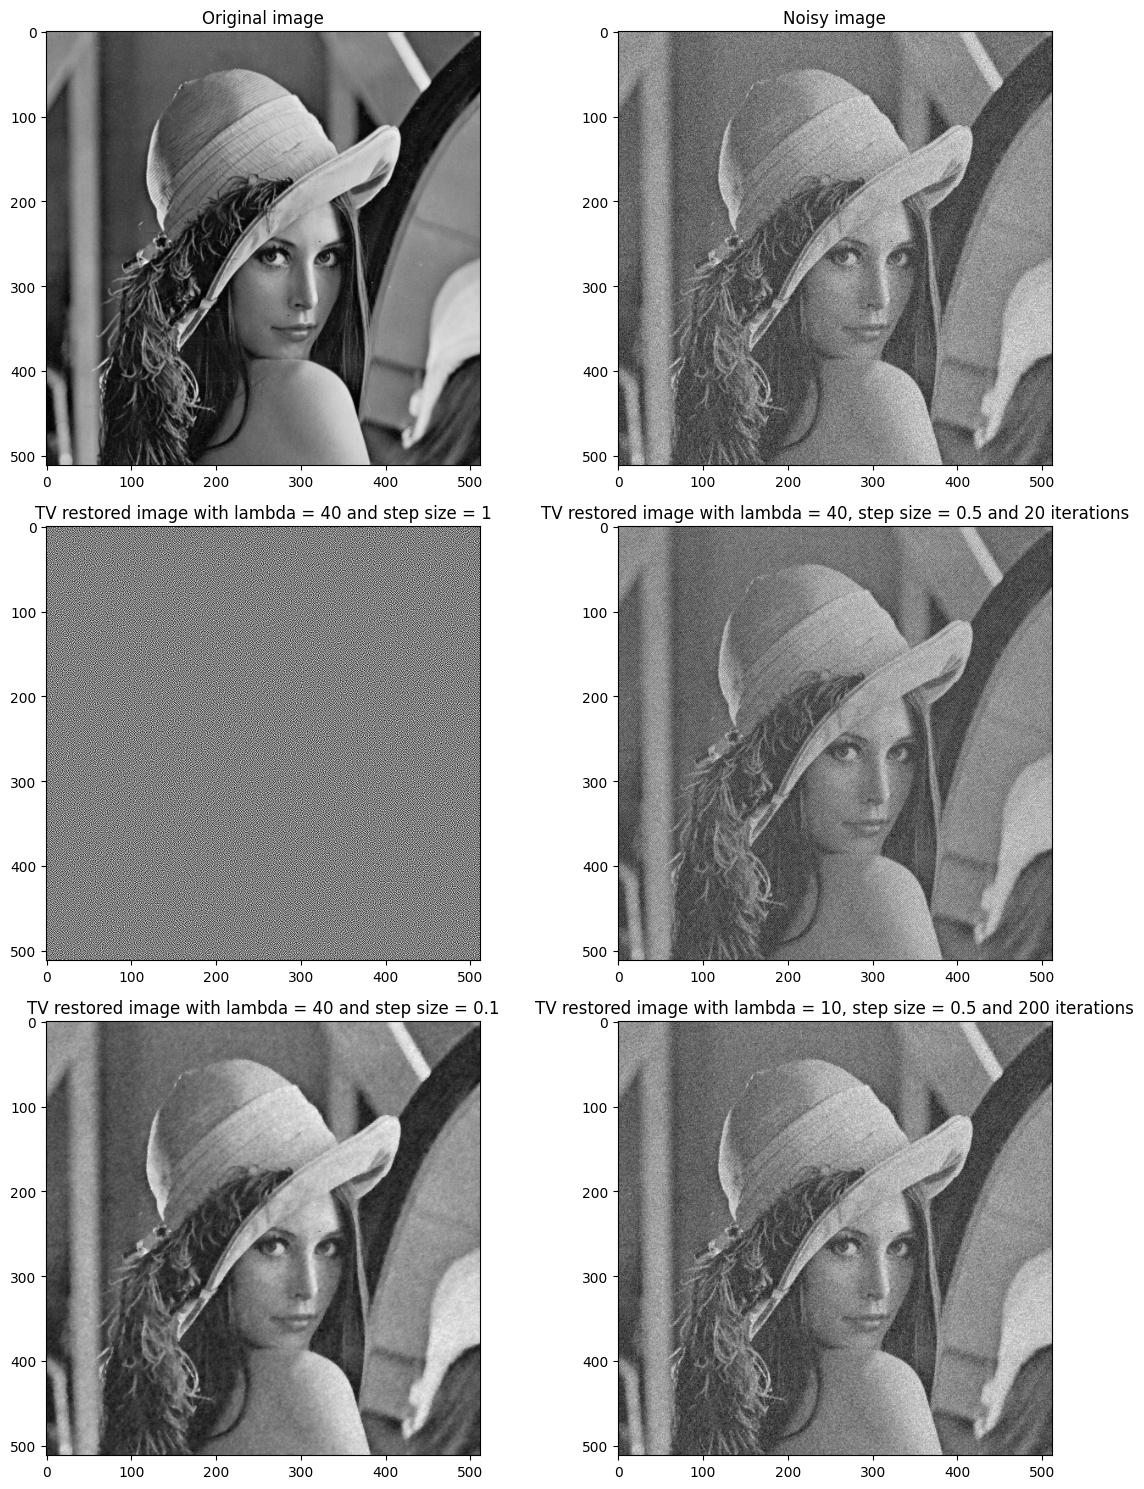

In [17]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

fig, ax = plt.subplots(3,2,figsize=(12,15))
ax[0][0].imshow(im, cmap='gray')
ax[0][1].imshow(imb, cmap='gray')
ax[1][0].imshow(u1,cmap='gray')
ax[1][1].imshow(u05, cmap='gray')
ax[2][0].imshow(u01, cmap='gray')
ax[2][1].imshow(u05inf, cmap='gray')
ax[0][0].set_title("Original image")
ax[0][1].set_title("Noisy image")
ax[1][0].set_title("TV restored image with lambda = 40 and step size = 1")
ax[1][1].set_title("TV restored image with lambda = 40, step size = 0.5 and 20 iterations")
ax[2][0].set_title("TV restored image with lambda = 40 and step size = 0.1")
ax[2][1].set_title("TV restored image with lambda = 10, step size = 0.5 and 200 iterations")
fig.tight_layout()


In [55]:
print("Energy for lambda = 40 and stepsize = 1 :",en1[-1])
print("Energy for lambda = 40 and stepsize = 0.5 :",en05[-1])
print("Energy for lambda = 40 and stepsize = 0.1 :",en01[-1])
print("Energy for lambda = 10 and stepsize = 1 :",en05inf[-1])

Energy for lambda = 40 and stepsize = 1 : 786643076806.4578
Energy for lambda = 40 and stepsize = 0.5 : 2250867484.23128
Energy for lambda = 40 and stepsize = 0.1 : 281005113.36712795
Energy for lambda = 10 and stepsize = 1 : 125253472.17733726


We can see that the gradient descent result depends on the step size used, values of the minimum energy get divided by more than 100 if you divide the step size by 10. This method is not very reliable and needs to be used with precaution. As can be seen on the plot below, a step size of 1 even diverges

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


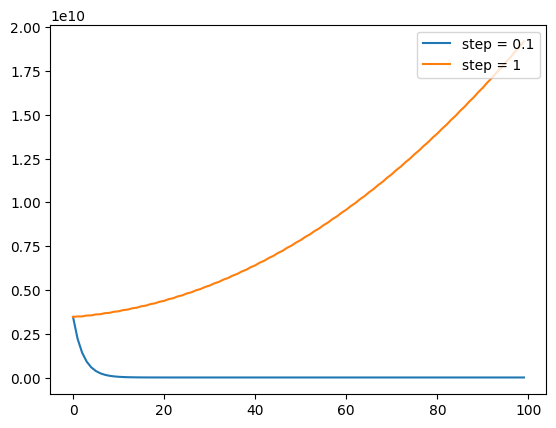

In [57]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ, label="step = 0.1")
plt.plot(energ2, label ='step = 1')
plt.legend(loc='upper right')


### 2.2 Projection Chambolle
This algorithm is slower than the gradient descent, however it is able to get an energy value as low as the lowest one the gradient descent was able to reach in 200 iterations but it did so in less than 100. What's more, if we compare this image with the best result of the gradient descent method, the latter is still visibly noisy while the former is smoother, although it has lost some detail in the process.

Energy for chambolle method, lambda=40: 133203255.05412836


Text(0.5, 1.0, 'Chambolle method restored image')

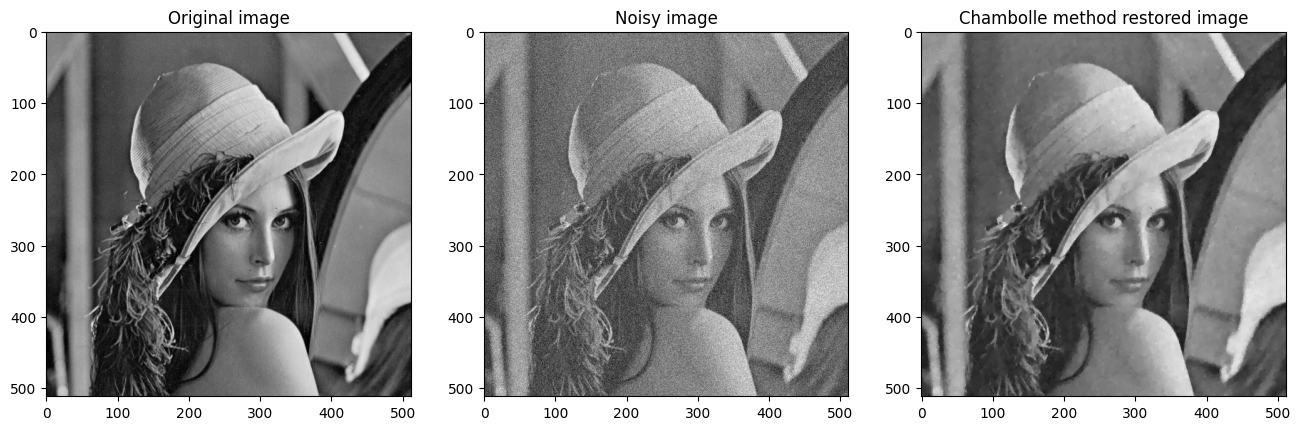

In [19]:
proj = vartotale_Chambolle(imb,40)
ener = E2_nonperiodique(im,proj,40)
print("Energy for chambolle method, lambda=40:",ener)

fig, ax = plt.subplots(1,3,figsize=(16,7))
ax[0].imshow(im,cmap='gray')
ax[1].imshow(imb, cmap='gray')
ax[2].imshow(proj, cmap='gray')
ax[0].set_title("Original image")
ax[1].set_title("Noisy image")
ax[2].set_title("Chambolle method restored image")

## III- Comparaison

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


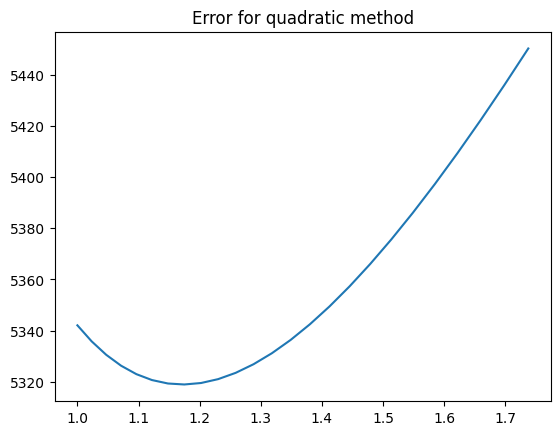

In [20]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk: 
    print (k)
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    

plt.plot(10**vk,erreur)
plt.title("Error for quadratic method")
plt.show()

In [24]:
left=0
right=0.25
step = 1/8
for i in range(4):
    l = []
    for j in np.linspace(left,right,25):
        l.append(norm2(minimisation_quadratique(imb,10**(j))-im))
    ind = np.argmin(np.array(l))
    best_lambda_q = left+(right-left)/24*ind
    left = best_lambda_q-step/(2**i)
    right = best_lambda_q+step/(2**i)

best_restau_quadra = minimisation_quadratique(imb,10**best_lambda_q)

print("Best lambda for quadratic method =",10**best_lambda_q)
print("Minimum difference =", norm2(best_restau_quadra-im))

Best lambda for quadratic method = 1.1687142337398764
Minimum difference = 5319.013176500428


1.5
1.52
1.54
1.56
1.58
1.6
1.62
1.6400000000000001
1.6600000000000001
1.6800000000000002
1.7000000000000002
1.7200000000000002
1.7400000000000002
1.7600000000000002
1.7800000000000002
1.8000000000000003
1.8200000000000003
1.8400000000000003
1.8600000000000003
1.8800000000000003
1.9000000000000004
1.9200000000000004
1.9400000000000004
1.9600000000000004
1.9800000000000004


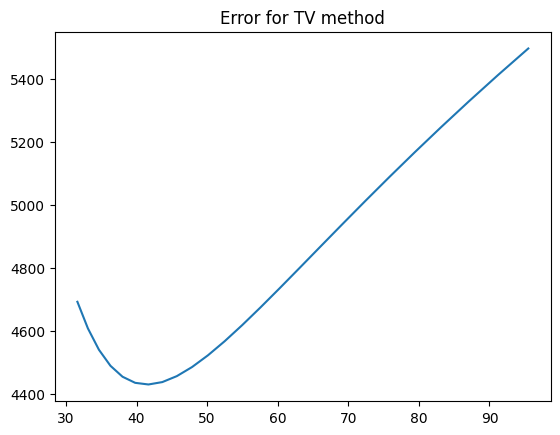

In [22]:
errvt=[]
vk=np.arange(1.5,2.0,0.02);
for k in vk: 
    print (k)
    restva=vartotale_Chambolle(imb,10**(k))
    errvt.append(norm2(restva-im))
    

plt.plot(10**vk,errvt)
plt.title("Error for TV method")
plt.show()

In [25]:
left=1.5
right=2.0
step = 1/4
for i in range(4):
    l = []
    for j in np.linspace(left,right,25):
        l.append(norm2(vartotale_Chambolle(imb,10**(j))-im))
    ind = np.argmin(np.array(l))
    best_lambda_tv = left+(right-left)/24*ind
    left = best_lambda_tv-step/(2**i)
    right = best_lambda_tv+step/(2**i)

best_restau_TV = vartotale_Chambolle(imb,10**best_lambda_tv)

print("Best lambda for TV method =",10**best_lambda_tv)
print("Minimum difference =", norm2(best_restau_TV-im))

Best lambda for TV method = 41.666945700453276
Minimum difference = 4430.0947483365935


Les meilleurs paramètres pour chacunes de ces méthodes sont:
- 1.18 pour la méthode quadratique
- 41.67 pour la variation totale
\
\
Et donnent les erreurs suivantes:
- 5319 pour la méthode quadratique
- 4430 pour la variation totale
\
\
Ils donnent les images suivantes:


Text(0.5, 1.0, 'Best TV restored image')

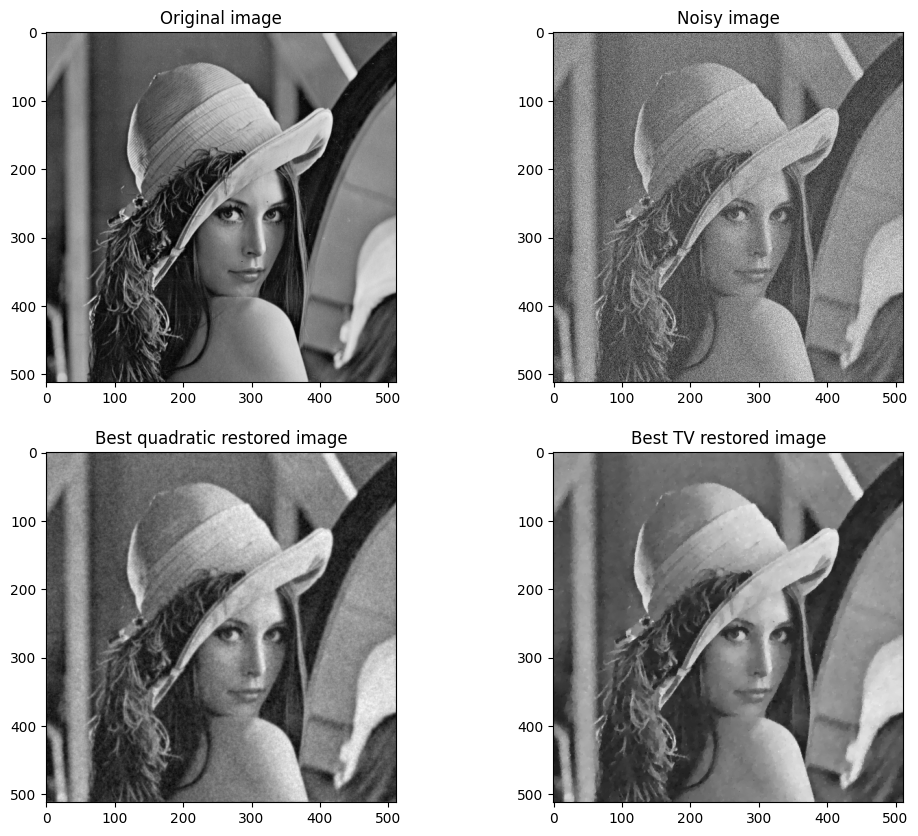

In [34]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
ax[0][0].imshow(im,cmap='gray')
ax[0][1].imshow(imb, cmap='gray')
ax[1][0].imshow(best_restau_quadra, cmap='gray')
ax[1][1].imshow(best_restau_TV, cmap='gray')
ax[0][0].set_title("Original image")
ax[0][1].set_title("Noisy image")
ax[1][0].set_title("Best quadratic restored image")
ax[1][1].set_title("Best TV restored image")

L'image obtenue par variation totale, se trouve non seulement être plus proche en norme de l'image originale que l'image obtenue par restauration quadratique mais est également plus esthétique. En effet, dans celle-ci le bruit a presque entièrement disparu même si l'image est plus lisse.